# 1) Prepare Machine
- Mount google drive
- Clone ssd-keras repository
- Download and prepare VOC07 and VOC12 datasets

In [0]:
#Some Settings for Preparing emilia-colab!
set_mount_drive = True
set_clone_repo = True
set_prepare_voc = False #Only use if you don't have the VOC7+12 HDF5s in your gdrive
set_install_tfgpu = True



In [2]:
if set_mount_drive:
  
  from google.colab import drive
  drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%%capture
if set_clone_repo:

  !git clone https://github.com/henritomas/ssd-keras.git

In [0]:
%%capture
if set_install_tfgpu:
  
  !pip install tensorflow-gpu==1.15.*
  !pip install larq

In [0]:
import os
import pathlib

def folder_not_here(FOLDER_PATH):
  if FOLDER_PATH in pathlib.Path.cwd().parts:
    while FOLDER_PATH in pathlib.Path.cwd().parts:
      return False
  elif not pathlib.Path(FOLDER_PATH).exists():
      return True

In [6]:
%cd /content/
#PJREDDIE's mirror sometimes the server is randomly slow to download, Oxford's server more consistent
# http://host.robots.ox.ac.uk/pascal/VOC/

if set_prepare_voc:

  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

/content


In [0]:
%%capture
if set_prepare_voc:

  VOC_IMAGES_DIR = '/content/voc7+12_images'

  !tar -xvf "/content/VOCtrainval_06-Nov-2007.tar"
  !tar -xvf "/content/VOCtest_06-Nov-2007.tar"
  !tar -xvf "/content/VOCtrainval_11-May-2012.tar"

  !mkdir $VOC_IMAGES_DIR
  !mv -v /content/VOCdevkit/VOC2007/JPEGImages/* $VOC_IMAGES_DIR
  !mv -v /content/VOCdevkit/VOC2012/JPEGImages/* $VOC_IMAGES_DIR

  #!mv /content/ssd-keras/dataset_voc_csv/2007_2012_person_trainval.csv $VOC_IMAGES_DIR
  #!mv /content/ssd-keras/dataset_voc_csv/2007_person_test.csv $VOC_IMAGES_DIR

# 2) Start of actual Jupyter Notebook

In [8]:
%cd /content/ssd-keras/

/content/ssd-keras


In [0]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.tfkeras_ssd_vgg import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.tensorflow_keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.tensorflow_keras_layer_DecodeDetections import DecodeDetections
from keras_layers.tensorflow_keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.tensorflow_keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.tensorflow_object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

In [0]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [0]:
!gdown https://drive.google.com/uc?id=1sBmajn6vOE7qJ8GnxUJt4fGPuffVUZox

Downloading...
From: https://drive.google.com/uc?id=1sBmajn6vOE7qJ8GnxUJt4fGPuffVUZox
To: /content/ssd-keras/VGG_ILSVRC_16_layers_fc_reduced.h5
86.1MB [00:00, 208MB/s]


In [0]:
import os
GDRIVE = '/content/gdrive/My Drive/emilia-colab/ssd-keras/'
VOC_HDF5_TRAIN = os.path.join(GDRIVE, 'dataset_hdf5/full_pascal_voc_07+12_trainval.h5')
VOC_HDF5_TEST = os.path.join(GDRIVE, 'dataset_hdf5/full_pascal_voc_07_test.h5')

SAVED_MODEL = '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_vgg_full_voc_68map/ssd_vgg_epoch-20_loss-6.02_val_loss-5.84.h5'

In [34]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
#weights_path = './VGG_ILSVRC_16_layers_fc_reduced.h5'
#model.load_weights(weights_path, by_name=True)
model.load_weights(SAVED_MODEL, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

#opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#opt = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)
opt = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=opt, loss=ssd_loss.compute_loss)

conv4_3 shape:  (?, 38, 38, 512)
fc7 shape:  (?, 19, 19, 1024)
conv6_2 shape (?, 10, 10, 512)
conv7_2 shape (?, 5, 5, 256)
conv8_2 shape (?, 3, 3, 256)
conv9_2 shape (?, 1, 1, 256)


In [0]:
##For some reason loading the model results in lower mAP when VGG (not in )

# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = SAVED_MODEL

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

In [13]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=VOC_HDF5_TRAIN)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=VOC_HDF5_TEST)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading evaluation-neutrality annotations: 100%|██████████| 4952/4952 [00:01<00:00, 4758.99it/s]
Number of images in the training dataset:	 16551
Number of images in the validation dataset:	  4952


In [0]:
# 3: Set the batch size.

batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

In [0]:
#%mkdir '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd7_voc_person'
WEIGHTS_DIR = os.path.join(GDRIVE, 'ssd_vgg_full_voc_68map/ssd_vgg_epoch-{epoch:02d}_loss-{loss:.2f}_val_loss-{val_loss:.2f}.h5')
LOG_DIR = os.path.join(GDRIVE, 'ssd_vgg_full_voc_68map/ssd_vgg_training_log.csv')

In [16]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath=WEIGHTS_DIR,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename=LOG_DIR,
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=3,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=1e-5)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             terminate_on_nan]

In [0]:
# TODO: Set the epochs to train for.
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 20
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/20
 155/1000 [===>..........................] - ETA: 10:59 - loss: 9.3412
Epoch 00001: val_loss improved from inf to 9.34117, saving model to /content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_vgg_full_voc_2nd/ssd_vgg_epoch-01_loss-11.21_val_loss-9.34.h5
1000/1000 [==============================] - 1724s 2s/step - loss: 11.2051 - val_loss: 9.3412
Epoch 2/20
 155/1000 [===>..........................] - ETA: 10:58 - loss: 8.5009
Epoch 00002: val_loss improved from 9.34117 to 8.50086, saving model to /content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_vgg_full_voc_2nd/ssd_vgg_epoch-02_loss-9.14_val_loss-8.50.h5
1000/1000 [==============================] - 1624s 2s/step - loss: 9.1415 - val_loss: 8.5009
Epoch 3/20
 155/1000 [===>..........................] - ETA: 11:02 - loss: 7.8539
Epoch 00003: val_loss improved from 8.50086 to 7.85386, saving model to /content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_vgg_full_voc_2nd/ssd_vgg_epoch-03_loss-8.48_val_loss-7.85.h5
1000/1000 [====

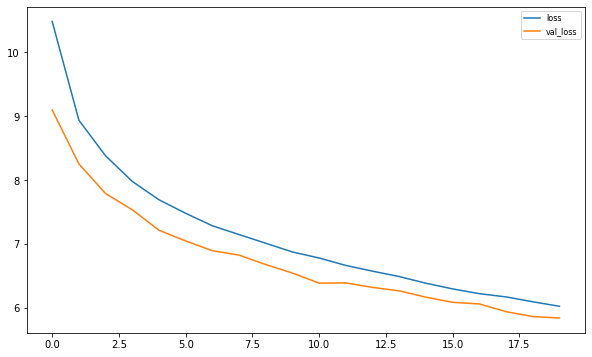

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

record_df = pd.read_csv(LOG_DIR)
#print(record_df['loss'])

plt.figure(figsize=(10,6))
plt.plot(record_df['loss'], label='loss')
plt.plot(record_df['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 8});

In [0]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [0]:
# 2: Generate samples

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

try:
    print("Image:", batch_filenames[i])
except:
    print("Using hdf5 cache: No image filepath")
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

# 3: Make a prediction

y_pred = model.predict(batch_images)

# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Using hdf5 cache: No image filepath

Ground truth boxes:

[[  1   1 145  19 216]
 [  1  25  70  82 348]
 [  1  36 100 207 500]
 [  1 172  90 326 500]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.    65.    90.   322.   495.  ]
 [  1.     0.92  26.    98.   187.   425.  ]
 [  1.     0.82  28.    78.    95.   213.  ]]


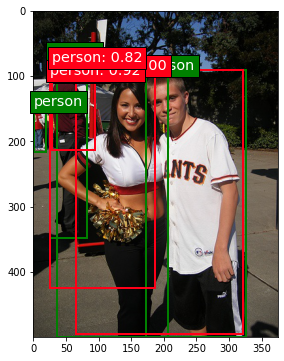

In [0]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background', 'person']

plt.figure(figsize=(10,6))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [18]:
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=VOC_HDF5_TEST)

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

Loading evaluation-neutrality annotations: 100%|██████████| 4952/4952 [00:01<00:00, 4783.15it/s]


In [35]:
model_mode = 'training'

evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    #batch_size=4,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 4952

Producing predictions batch-wise: 100%|██████████| 619/619 [22:26<00:00,  2.18s/it]
Matching predictions to ground truth, class 1/20.: 100%|██████████| 11165/11165 [00:01<00:00, 10451.11it/s]
Matching predictions to ground truth, class 2/20.: 100%|██████████| 4718/4718 [00:00<00:00, 14812.22it/s]
Matching predictions to ground truth, class 3/20.: 100%|██████████| 41363/41363 [00:03<00:00, 13423.11it/s]
Matching predictions to ground truth, class 4/20.: 100%|██████████| 22304/22304 [00:01<00:00, 12814.67it/s]
Matching predictions to ground truth, class 5/20.: 100%|██████████| 60747/60747 [00:02<00:00, 26900.74it/s]
Matching predictions to ground truth, class 6/20.: 100%|██████████| 4629/4629 [00:00<00:00, 12835.08it/s]
Matching predictions to ground truth, class 7/20.: 100%|██████████| 74711/74711 [00:05<00:00, 13773.43it/s]
Matching predictions to ground truth, class 8/20.: 100%|██████████| 17055/17055 [00:01<00:00, 12367.29it/s]
Matchi

In [36]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

aeroplane     AP    0.74
bicycle       AP    0.776
bird          AP    0.67
boat          AP    0.585
bottle        AP    0.346
bus           AP    0.779
car           AP    0.795
cat           AP    0.837
chair         AP    0.461
cow           AP    0.705
diningtable   AP    0.649
dog           AP    0.785
horse         AP    0.831
motorbike     AP    0.751
person        AP    0.705
pottedplant   AP    0.375
sheep         AP    0.678
sofa          AP    0.699
train         AP    0.786
tvmonitor     AP    0.687

              mAP   0.682
